# Chapter 10 Exercises

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Use a VARMA model to predict realdpi and realcons
In this chapter, we used a VAR(p) model. However, we used the VARMAX function from
statsmodels to do so, meaning that we can easily extend the VAR(p) model to a
VARMA(p,q) model. In this exercise, use a VARMA(p,q) model to forecast realdpi
and realcons.
1. Use the same train and test sets as in this chapter.
2. Generate a list of unique (p,q) combinations.
3. Rename the optimize_VAR function to optimize_VARMA, and adapt it to loop
over all unique (p,q) combinations.
4. Select the model with the lowest AIC, and perform the Granger causality test.
Pass in the largest order among (p,q). Is the VARMA(p,q) model valid?
5. Perform residual analysis.
6. Make forecasts on a four-step window over the test set. Use the last known value
method as a baseline.
7. Calculate the MAPE. Is it lower or higher than that of our VAR(3) model?

#### Dataset

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


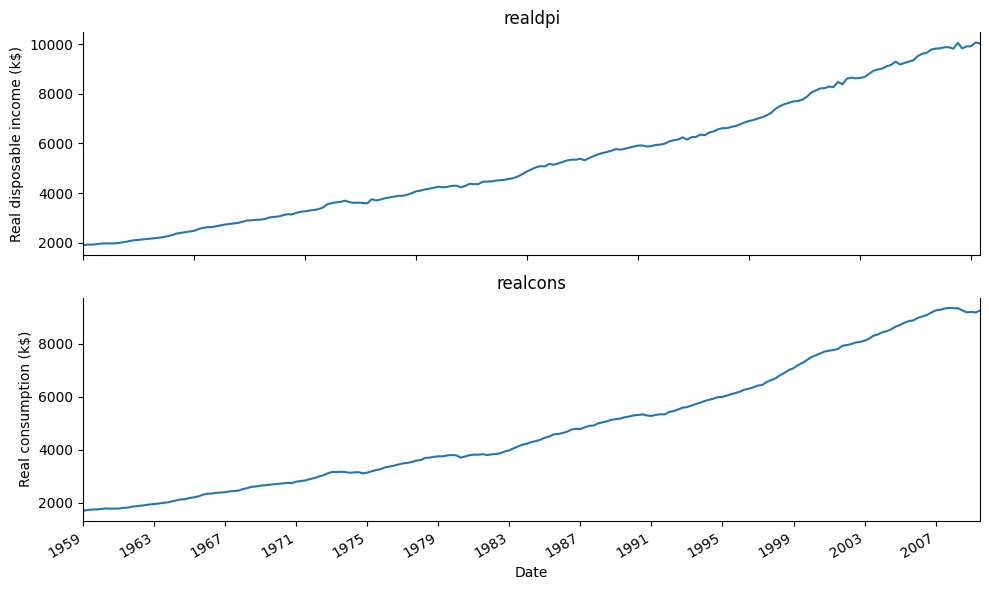

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.set_xlim(0, 202) 

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.set_xlim(0, 202) 

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

#### ADF Test for both sets

In [8]:
# Augmented Dickey-Fuller (ADF) test for 'realdpi'
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
if ad_fuller_result_1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print('\n---------------------\n')

# Augmented Dickey-Fuller (ADF) test for 'realcons'
ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
if ad_fuller_result_2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print()

realdpi
ADF Statistic: 2.9860253519546878
p-value: 1.0
p-value > alpha; H0: Not Stationary

---------------------

realcons
ADF Statistic: 1.5499123380509559
p-value: 0.9976992503412904
p-value > alpha; H0: Not Stationary



#### ADF Test for both first-order differencing sets

In [10]:
realdpi_diff = macro_econ_data['realdpi'].diff()[1:]   # First-Order differencing for 'realdpi'
ad_fuller_result_1 = adfuller(realdpi_diff)

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')
if ad_fuller_result_1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

print('\n---------------------\n')

realcons_diff = macro_econ_data['realcons'].diff()[1:] # First-Order differencing for 'realcons'
ad_fuller_result_2 = adfuller(realcons_diff)

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')
if ad_fuller_result_2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")
    
print()

realdpi
ADF Statistic: -8.864893340673012
p-value: 1.449360615910768e-14
p-value < alpha; Ha: Stationary

---------------------

realcons
ADF Statistic: -4.2043060808452495
p-value: 0.0006479282158627493
p-value < alpha; Ha: Stationary



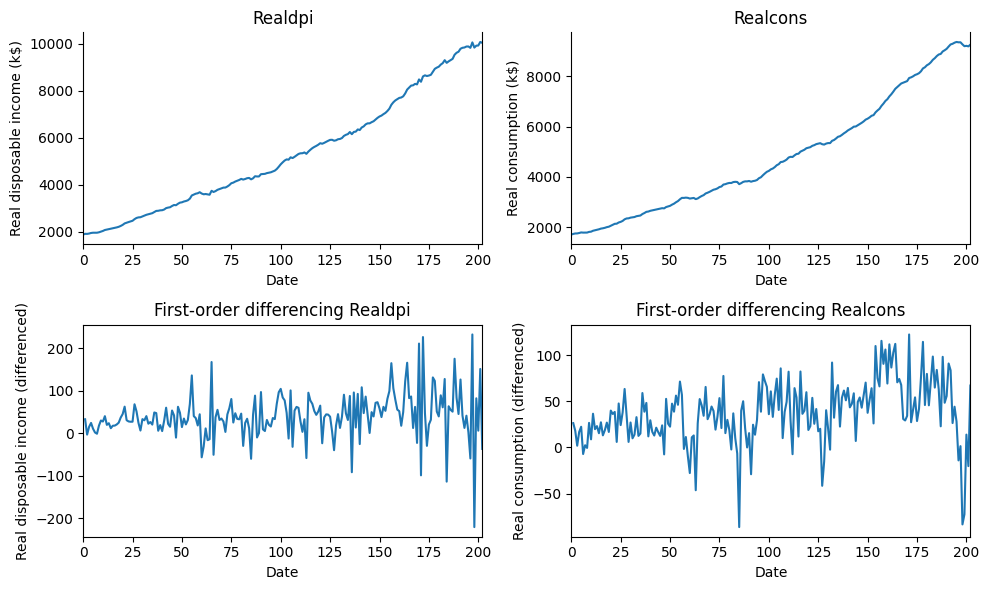

In [11]:
# Set up the figure for 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# 1. Plot 'realdpi'
axes[0, 0].plot(macro_econ_data['realdpi'])
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Real disposable income (k$)')
axes[0, 0].set_title('Realdpi')
axes[0, 0].spines['top'].set_alpha(0)
axes[0, 0].set_xlim(0, 202)

# 2. Plot 'realcons'
axes[0, 1].plot(macro_econ_data['realcons'])
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Real consumption (k$)')
axes[0, 1].set_title('Realcons')
axes[0, 1].spines['top'].set_alpha(0)
axes[0, 1].set_xlim(0, 202)

# 3. Plot First-order differencing realdpi
axes[1, 0].plot(realdpi_diff)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Real disposable income (differenced)')
axes[1, 0].set_title('First-order differencing Realdpi')
axes[1, 0].set_xlim(0, 202)

# 4. Plot First-order differencing realcons
axes[1, 1].plot(realcons_diff)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Real consumption (differenced)')
axes[1, 1].set_title('First-order differencing Realcons')
axes[1, 1].set_xlim(0, 202)

# Layout adjustments
plt.tight_layout()
plt.show()

#### Fitting many VARMA(p,q) models to select the one with the smallest Akaike information criterion (AIC)

In [13]:
def optimize_VARMA(endog, parameters_list):
    """
        Returns a dataframe with parameters (p,d) and corresponding AIC
        
        endog - the observed variable
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMA = optimize_VARMA(train, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 0)",3123.070081
1,"(2, 1)",3124.096357
2,"(1, 3)",3125.122280
3,"(3, 2)",3125.572328
4,"(2, 3)",3125.763937
5,"(1, 2)",3126.993365
6,"(3, 1)",3129.008361
7,"(1, 1)",3129.563934
8,"(2, 2)",3129.938160
9,"(2, 0)",3130.091668


    From the optimization, p=3 and q=0.

#### Granger-cause Test

In [17]:
print('realcons Granger-causes realdpi?')
print('------------------')
# Here we thus test if realcons Granger-causes realdpi
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3]) #<==== p=3

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_1 = granger_1[3][0]['ssr_ftest'][1] 
print()

if ssr_p_value_1 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")


print('\nrealdpi Granger-causes realcons?')
print('------------------')
# Here we test if realdpi Granger-causes realcons
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3]) #<==== p=3

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_2 = granger_1[3][0]['ssr_ftest'][1] 
print()

if ssr_p_value_2 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")

realcons Granger-causes realdpi?
------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

Yes. p-value < alpha; Ha: Granger causality exists.

realdpi Granger-causes realcons?
------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3

Yes. p-value < alpha; Ha: Granger causality exists.


In [18]:
# Define a VAR(3,0) model on train set
best_model = VARMAX(train, order=(3,0))

# Fit the model
best_model_fit = best_model.fit(disp=False)

# Display the summary
best_model_fit.summary()

Dep. Variable:,"['realdpi', 'realcons']",No. Observations:,162
Model:,VAR(3),Log Likelihood,-1544.535
,+ intercept,AIC,3123.070
Date:,"Wed, 19 Feb 2025",BIC,3175.559
Time:,14:40:01,HQIC,3144.381
Sample:,0,,
,- 162,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.03",Jarque-Bera (JB):,"43.85, 4.35"
Prob(Q):,"0.91, 0.87",Prob(JB):,"0.00, 0.11"
Heteroskedasticity (H):,"4.44, 3.59",Skew:,"0.14, -0.21"


#### Analyzing Residuals

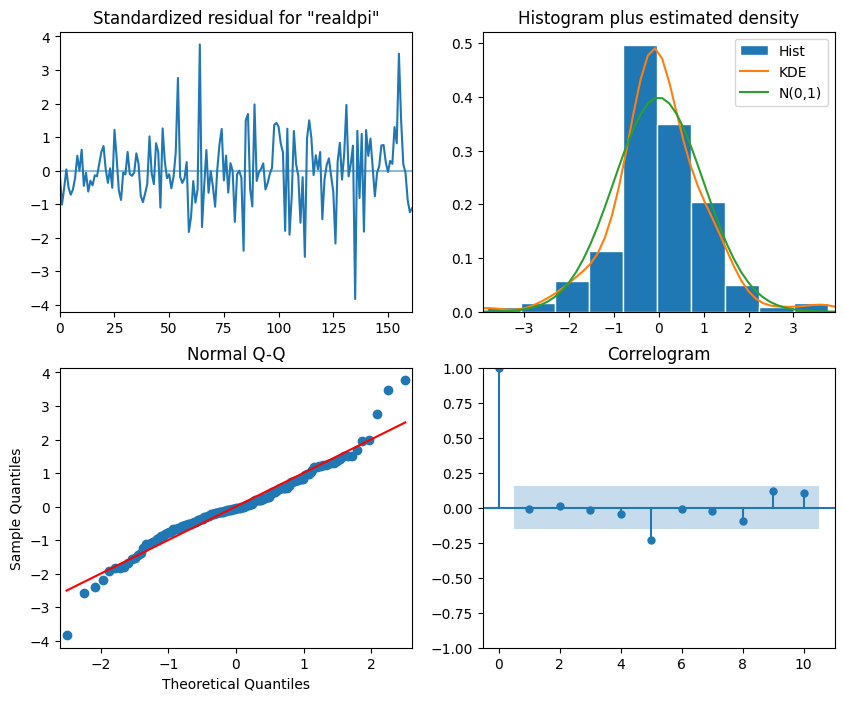

In [20]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

# Passing variable=0 specifies that we want plots for the residuals of realdpi, since it is the first variable that was passed to the VAR model

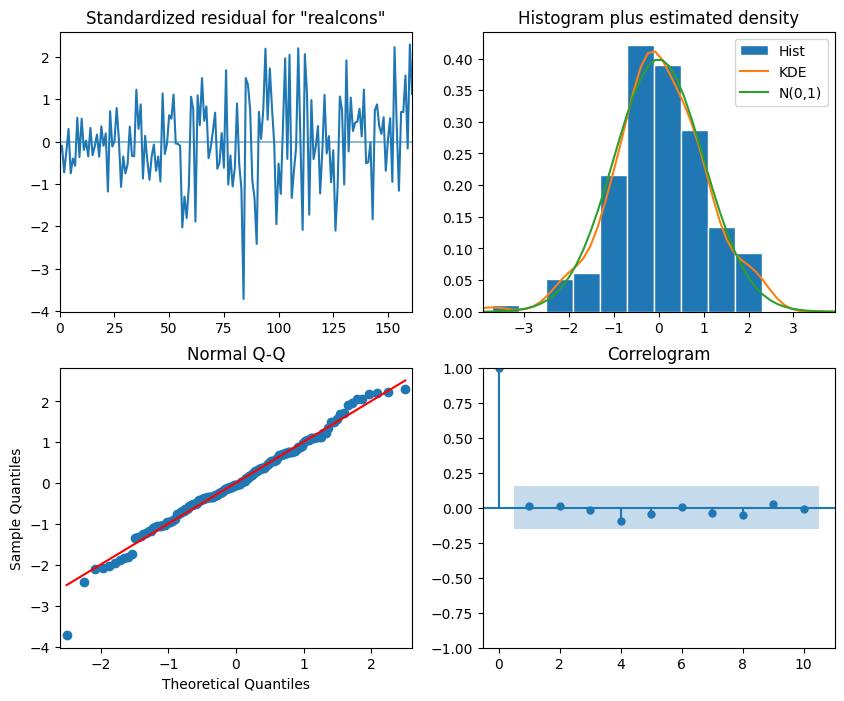

In [21]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

# Passing variable=1 specifies that we want plots for the residuals of realcons, since it is the second variable that was passed to the VAR model

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals_realdpi = best_model_fit.resid['realdpi']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realdpi = acorr_ljungbox(residuals_realdpi, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realdpi['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realdpi

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.011646,0.914060
2,0.029457,0.985379
3,0.075687,0.994586
4,0.378056,0.984234
5,9.143186,0.103487
6,9.166061,0.164452
7,9.270740,0.233798
8,10.812743,0.212537
9,13.318832,0.148702
10,15.287954,0.121911


In [23]:
# Extract the residuals (errors) from the fitted model
residuals_realcons = best_model_fit.resid['realcons']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realcons = acorr_ljungbox(residuals_realcons, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realcons['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realcons

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.023588,0.877938
2,0.068582,0.966290
3,0.068660,0.995312
4,0.235537,0.993586
5,0.377501,0.995927
6,0.787221,0.992412
7,1.015069,0.994582
8,2.150413,0.976050
9,2.437165,0.982526
10,2.442858,0.991683


#### Forecasting

In [25]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMA':

        realdpi_pred_VARMA = []
        realcons_pred_VARMA = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))  #<==== VARMA(3,0)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMA.extend(oos_pred_realdpi)
            realcons_pred_VARMA.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMA, realcons_pred_VARMA
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [26]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4   # We want to forecast four time steps into the future at a time, which is equivalent to 1 year

realdpi_pred_VARMA, realcons_pred_VARMA = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMA')

Recall that the VARMA(3,0) model requires the series to be stationary, meaning that we have transformed forecasts. We must then integrate them using the cumulative sum to bring them back to the original scale of the data.

In [28]:
test = endog[163:]  # Test set

test['realdpi_pred_VARMA'] = pd.Series()   # Create column in test dataframe
test['realdpi_pred_VARMA'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMA)    # Integrate the forecasts using the cumulative sum

test['realcons_pred_VARMA'] = pd.Series()  # Create column in test dataframe
test['realcons_pred_VARMA'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMA) # Integrate the forecasts using the cumulative sum

test 

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA
163,7887.7,7389.2,7829.225436,7354.324973
164,8053.4,7501.3,7897.191819,7430.257899
165,8135.9,7571.8,7960.567957,7496.633321
166,8222.3,7645.9,8014.759322,7556.618023
167,8234.6,7713.5,8080.707471,7631.002170
168,8296.5,7744.3,8142.399086,7692.851914
169,8273.7,7773.5,8200.132090,7753.873091
170,8484.5,7807.7,8259.372991,7812.543024
171,8385.5,7930.0,8264.396980,7864.643623
172,8611.6,7957.3,8320.869302,7895.068367


At this point, test contains the actual values of the test set and the predictions from the VARMA(3,0) model. We can now add the forecasts from our baseline method, which simply predicts the last known value for the next four timesteps.

In [30]:
# Generate forecasts using the 'last' method with rolling_forecast function
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last     # Add the 'realdpi_pred_last' predictions to the 'test' DataFrame
test['realcons_pred_last'] = realcons_pred_last   # Add the 'realcons_pred_last' predictions to the 'test' DataFrame

test

,realdpi,realcons,realdpi_pred_VARMA,realcons_pred_VARMA,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.225436,7354.324973,7716.0,7199.9
164,8053.4,7501.3,7897.191819,7430.257899,7716.0,7199.9
165,8135.9,7571.8,7960.567957,7496.633321,7716.0,7199.9
166,8222.3,7645.9,8014.759322,7556.618023,7716.0,7199.9
167,8234.6,7713.5,8080.707471,7631.002170,8135.9,7571.8
168,8296.5,7744.3,8142.399086,7692.851914,8135.9,7571.8
169,8273.7,7773.5,8200.132090,7753.873091,8135.9,7571.8
170,8484.5,7807.7,8259.372991,7812.543024,8135.9,7571.8
171,8385.5,7930.0,8264.396980,7864.643623,8273.7,7773.5
172,8611.6,7957.3,8320.869302,7895.068367,8273.7,7773.5


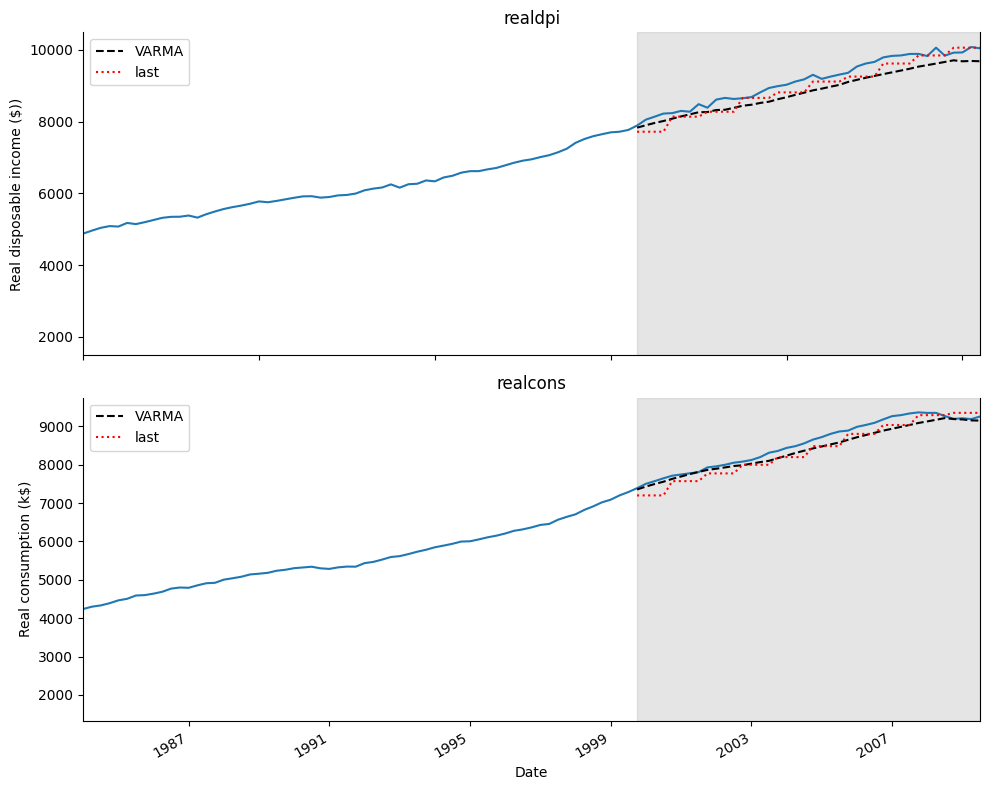

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VARMA'], 'k--', label='VARMA')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VARMA'], 'k--', label='VARMA')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
# Calculate MAPE for each forecast
mape_realdpi_VARMA = mape(test['realdpi'], test['realdpi_pred_VARMA'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMA = mape(test['realcons'], test['realcons_pred_VARMA'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

# Display MAPE results
print(f'realdpi MAPE for last-value Baseline: {mape_realdpi_last:.2f}')
print(f'realdpi MAPE for VARMA(3,0) Forecast: {mape_realdpi_VARMA:.2f}')
print()
print(f'realcons MAPE for last-value Baseline: {mape_realcons_last:.2f}')
print(f'realcons MAPE for VARMA(3,0) Forecast: {mape_realcons_VARMA:.2f}')

realdpi MAPE for last-value Baseline: 2.26
realdpi MAPE for VARMA(3,0) Forecast: 3.14

realcons MAPE for last-value Baseline: 2.46
realcons MAPE for VARMA(3,0) Forecast: 1.77


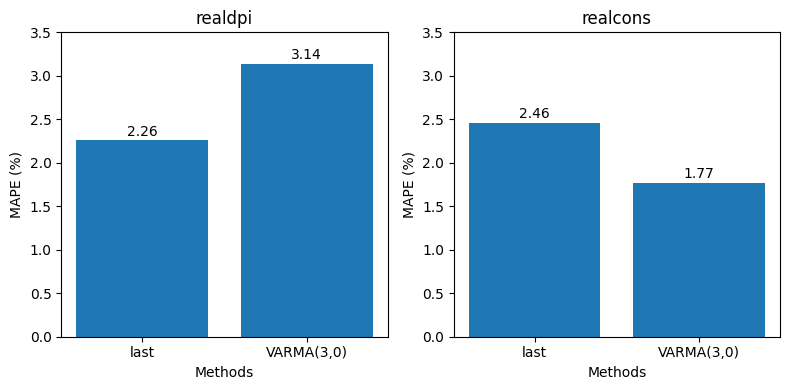

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

x = ['last', 'VARMA(3,0)']
y1 = [mape_realdpi_last, mape_realdpi_VARMA]
y2 = [mape_realcons_last, mape_realcons_VARMA]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3.5)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

Using a VARMA model did not change anything, since the VARMA(3,0) achieved the lowest AIC, which is equivalent to a VAR(3) model, just like we obtained in chapter 10. Let's try a VARMAX model to see if we can get an improvement.

# 2. Use a VARMAX model to predict realdpi and realcons
Again, since we used the VARMAX function from statsmodels, we know that we can
also add exogenous variables to the model, just like in SARIMAX. In this exercise, use
the VARMAX model to forecast realdpi and realcons.
1. Use the same train and test sets as in this chapter.
2. Generate a list of unique (p,q) combinations.
3. Rename the optimize_VAR function to optimize_VARMAX, and adapt it to loop
over all the unique (p,q) combinations and exogenous variables.
4. Select the model with the lowest AIC, and perform the Granger causality test.
Pass in the largest order among (p,q). Is the VARMAX(p,q) model valid?
5. Perform residual analysis.
6. Make forecasts on a one-step window over the test set. Use the last known value
method as a baseline.
7. Calculate the MAPE. Did the model perform better than the baseline?

In [37]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Returns a dataframe with (p,q) and AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list of (p,q) tuples
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue
    
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [38]:
# Define the targets
endog = macro_econ_data[['realdpi', 'realcons']]

# Use their diferenced version for modeling, since VARMA requires the time series to be stationary
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

# Select the exogenous variables. Note that they do not be to be stationary to be used
exog_cols = macro_econ_data.columns.drop(['year', 'quarter', 'realdpi', 'realcons'])

# Make sure that the index of exog is aligned with train
exog = macro_econ_data[exog_cols][1:163]

# Split into a trainig and test set just like in chapter 10
train = endog_diff[:162]
test = endog_diff[162:]

# Determine the range of possible values for p and q
p = range(0, 4, 1)
q = range(0, 4, 1)

# Generate a list of unique (p,q) combinations
parameters = product(p, q)
parameters_list = list(parameters)

# Run the optimization
result_df_VARMAX = optimize_VARMAX(train, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 0)",3113.465986
1,"(0, 1)",3117.326728
2,"(2, 0)",3117.855528
3,"(1, 1)",3121.109477
4,"(3, 0)",3121.521262
5,"(0, 3)",3122.398464
6,"(0, 2)",3122.999945
7,"(1, 2)",3125.051544
8,"(2, 1)",3126.805587
9,"(1, 3)",3127.566148


    From the optimization, p=1 and q=0.

In [40]:
print('realcons Granger-causes realdpi?')
print('------------------')
# Here we thus test if realcons Granger-causes realdpi
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [1]) #<==== p=1

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_1 = granger_1[1][0]['ssr_ftest'][1] 
print()

if ssr_p_value_1 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")


print('\nrealdpi Granger-causes realcons?')
print('------------------')
# Here we test if realdpi Granger-causes realcons
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [1]) #<==== p=1

# Extracting the p-value from the'ssr_ftest' tuple
ssr_p_value_2 = granger_2[1][0]['ssr_ftest'][1] 
print()

if ssr_p_value_2 < 0.05:
    print("Yes. p-value < alpha; Ha: Granger causality exists.")
else:
    print("No. p-value > alpha; H0: No Granger causality.")

realcons Granger-causes realdpi?
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=35.3881 , p=0.0000  , df=1
likelihood ratio test: chi2=32.5962 , p=0.0000  , df=1
parameter F test:         F=34.8599 , p=0.0000  , df_denom=198, df_num=1

Yes. p-value < alpha; Ha: Granger causality exists.

realdpi Granger-causes realcons?
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1
ssr based chi2 test:   chi2=7.8540  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7045  , p=0.0055  , df=1
parameter F test:         F=7.7368  , p=0.0059  , df_denom=198, df_num=1

Yes. p-value < alpha; Ha: Granger causality exists.


In [41]:
# Define a VARMA(1,0) model on train set
best_model = VARMAX(train, exog, order=(1,0)) #<==== exog!

# Fit the model
best_model_fit = best_model.fit(disp=False)

# Display the summary
best_model_fit.summary()

Dep. Variable:,"['realdpi', 'realcons']",No. Observations:,162
Model:,VARX(1),Log Likelihood,-1527.733
,+ intercept,AIC,3113.466
Date:,"Wed, 19 Feb 2025",BIC,3203.006
Time:,14:47:14,HQIC,3149.821
Sample:,0,,
,- 162,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.08, 0.29",Jarque-Bera (JB):,"40.79, 18.63"
Prob(Q):,"0.78, 0.59",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.80, 2.63",Skew:,"0.12, -0.62"


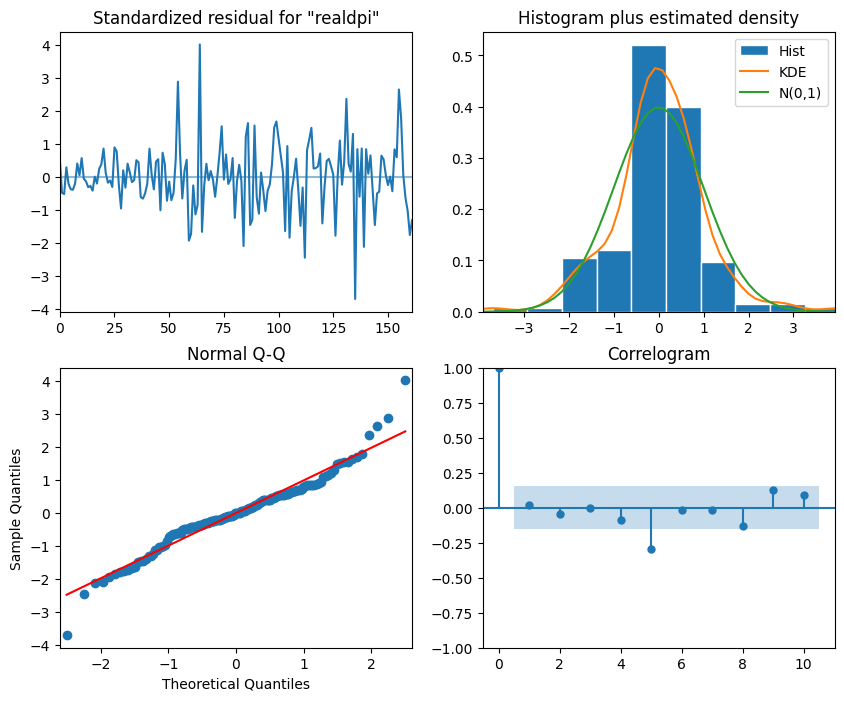

In [42]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

# Passing variable=0 specifies that we want plots for the residuals of realdpi, since it is the first variable that was passed to the VARMAX model

In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals_realdpi = best_model_fit.resid['realdpi']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realdpi = acorr_ljungbox(residuals_realdpi, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realdpi['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realdpi

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.075524,0.783458
2,0.411993,0.813836
3,0.412622,0.937623
4,1.792401,0.773872
5,16.220383,0.006242
6,16.286550,0.012296
7,16.327306,0.022289
8,19.273314,0.013464
9,21.990612,0.008909
10,23.487438,0.009084


Here, we confirm what we saw on Correlogram, there is some autocorrelation starting at lag 5. For the sake of completing the exercise, let's keep going, especially becasue the visual inspection of the residuals all point to the conclusion that the residuals behave like white noise.

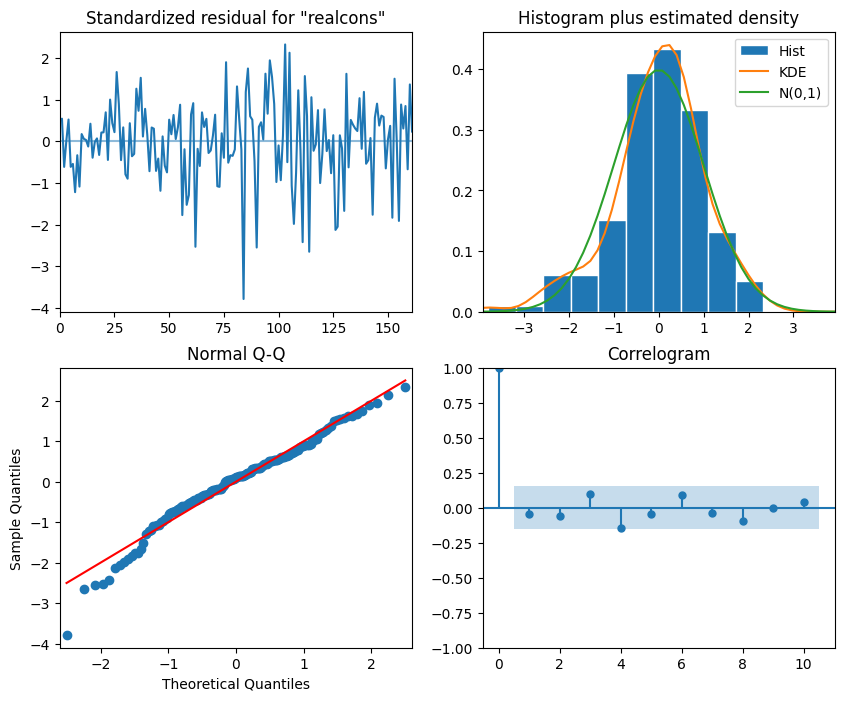

In [45]:
# Diagnostic plots for the model, including residuals and other model checks
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

# Passing variable=0 specifies that we want plots for the residuals of realdpi, since it is the second variable that was passed to the VARMAX model

In [46]:
# Extract the residuals (errors) from the fitted model
residuals_realcons = best_model_fit.resid['realcons']

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_realcons = acorr_ljungbox(residuals_realcons, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_realcons['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_realcons

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.267015,0.605341
2,2.020628,0.364105
3,6.832538,0.077431
4,9.591459,0.047902
5,11.193142,0.047682
6,13.395337,0.037170
7,13.696266,0.056855
8,17.971023,0.021445
9,17.971437,0.035506
10,18.222728,0.051321


We can see that sometimes, there is a bit of judgement to be made when we are in a grey zone.

In [48]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VARMAX':

        realdpi_pred_VARMAX = []
        realcons_pred_VARMAX = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], exog[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1, exog=exog.iloc[-1])    # Use the exogenous variable to 
                                                                                       # generate predictions
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VARMAX.extend(oos_pred_realdpi)
            realcons_pred_VARMAX.extend(oos_pred_realcons)
        
        return realdpi_pred_VARMAX, realcons_pred_VARMAX
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [49]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # We can only predict the next timestep, since we have exogenous variables (just like the SARIMAX model)

exog = macro_econ_data[exog_cols][1:]

realdpi_pred_VARMAX, realcons_pred_VARMAX = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VARMAX')

In [50]:
test = endog[163:]

test['realdpi_pred_VARMAX'] = pd.Series()
test['realdpi_pred_VARMAX'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VARMAX)

test['realcons_pred_VARMAX'] = pd.Series()
test['realcons_pred_VARMAX'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VARMAX)

test

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX
163,7887.7,7389.2,7785.091732,7409.320799
164,8053.4,7501.3,7822.256812,7547.737390
165,8135.9,7571.8,7865.564614,7684.484527
166,8222.3,7645.9,7901.102061,7813.280685
167,8234.6,7713.5,7939.171479,7939.001719
168,8296.5,7744.3,7972.423436,8047.018152
169,8273.7,7773.5,7992.738721,8158.863639
170,8484.5,7807.7,8017.107374,8249.602162
171,8385.5,7930.0,8024.445710,8347.232157
172,8611.6,7957.3,8069.055900,8422.185315


In [51]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VARMAX,realcons_pred_VARMAX,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7785.091732,7409.320799,7716.0,7199.9
164,8053.4,7501.3,7822.256812,7547.737390,7765.9,7286.4
165,8135.9,7571.8,7865.564614,7684.484527,7887.7,7389.2
166,8222.3,7645.9,7901.102061,7813.280685,8053.4,7501.3
167,8234.6,7713.5,7939.171479,7939.001719,8135.9,7571.8
168,8296.5,7744.3,7972.423436,8047.018152,8222.3,7645.9
169,8273.7,7773.5,7992.738721,8158.863639,8234.6,7713.5
170,8484.5,7807.7,8017.107374,8249.602162,8296.5,7744.3
171,8385.5,7930.0,8024.445710,8347.232157,8273.7,7773.5
172,8611.6,7957.3,8069.055900,8422.185315,8484.5,7807.7


In [52]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
# Calculate MAPE for each forecast
mape_realdpi_VARMAX = mape(test['realdpi'], test['realdpi_pred_VARMAX'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VARMAX = mape(test['realcons'], test['realcons_pred_VARMAX'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

# Display MAPE results
print(f' realdpi MAPE for last-value Baseline: {mape_realdpi_last:.2f}')
print(f'realdpi MAPE for VARMAX(1,0) Forecast: {mape_realdpi_VARMAX:.2f}')
print()
print(f' realcons MAPE for last-value Baseline: {mape_realcons_last:.2f}')
print(f'realcons MAPE for VARMAX(1,0) Forecast: {mape_realcons_VARMAX:.2f}')

 realdpi MAPE for last-value Baseline: 1.43
realdpi MAPE for VARMAX(1,0) Forecast: 11.33

 realcons MAPE for last-value Baseline: 1.37
realcons MAPE for VARMAX(1,0) Forecast: 5.42


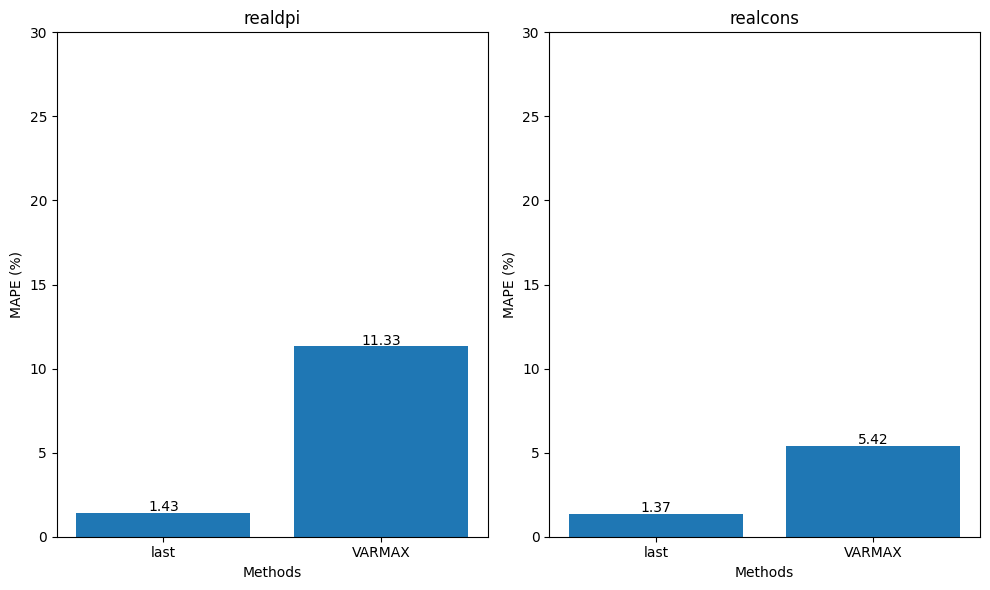

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VARMAX']
y1 = [mape_realdpi_last, mape_realdpi_VARMAX]   
y2 = [mape_realcons_last, mape_realcons_VARMAX] 

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 30)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 30)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()

Clearly, using a VARMAX model is a very bad idea in this situation, since it achieves a very high MAPE compared to a simple baseline. Note that we cannot compare this performance to the VAR and VARMA models, since the forecast window is different for VARMAX.